In [8]:
import pandas as pd

# Raw URLs (make sure you're using the real raw.githubusercontent.com versions)
url_pos = "https://raw.githubusercontent.com/Jeffateth/AllergenPredict/main/positive.csv"
url_neg = "https://raw.githubusercontent.com/Jeffateth/AllergenPredict/main/negative.csv"

# Only load the two columns you're interested in
use_columns = ['Epitope.1', 'Epitope.11']

positive_df = pd.read_csv(url_pos, usecols=use_columns)
negative_df = pd.read_csv(url_neg, usecols=use_columns)

# Add labels
positive_df['label'] = 1
negative_df['label'] = 0

# Combine the datasets
df = pd.concat([positive_df, negative_df], ignore_index=True)
df = df.rename(columns={'Epitope.1': 'sequence', 'Epitope.11': 'protein_url'})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

# Preview
df.head()


,sequence,protein_url,label
0,FGGRAEWGTNTADNDDTDGNGHGTHTASTAA,http://www.uniprot.org/uniprot/P9WEW4,0
1,TEEEKNRLNFLKKISQRYQK,http://www.uniprot.org/uniprot/P02663,0
2,YQELGV,http://www.uniprot.org/uniprot/D2TGC3,1
3,LSLSQSKVLP,http://www.uniprot.org/uniprot/P02666,0
4,NLGTTVRASVHIKLP,http://www.uniprot.org/uniprot/Q004B5,0


In [13]:
# Count the number of positive and negative samples
label_counts = df['label'].value_counts()

# Display the results
print("Number of negative samples (label = 0):", label_counts.get(0, 0))
print("Number of positive samples (label = 1):", label_counts.get(1, 0))


Number of negative samples (label = 0): 7021
Number of positive samples (label = 1): 5293


In [9]:
from collections import Counter
import numpy as np

AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'

def compute_aac(seq):
    count = Counter(seq)
    total = len(seq)
    return np.array([count[aa]/total if aa in count else 0 for aa in AMINO_ACIDS])

# Apply AAC to all sequences
X = np.vstack(df['sequence'].apply(compute_aac))
y = df['label'].values


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.65      0.77      0.70      1391
           1       0.60      0.45      0.52      1072

    accuracy                           0.63      2463
   macro avg       0.62      0.61      0.61      2463
weighted avg       0.63      0.63      0.62      2463

ROC AUC Score: 0.6236758559824886


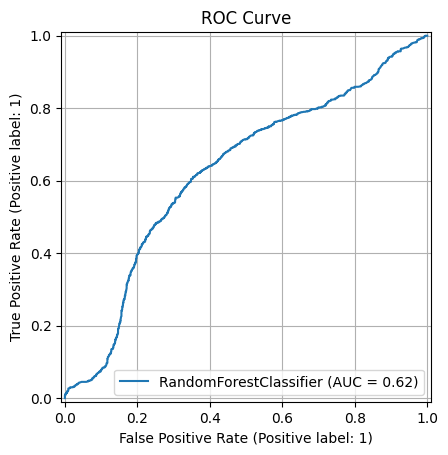

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve")
plt.grid(True)
plt.show()
